<a href="https://colab.research.google.com/github/Quotermain/sber_stock_analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

from google.colab import drive
drive.mount('/content/drive')

In [11]:
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

In [3]:
import datetime
from os import listdir
import pickle
  
import re
  
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


In [4]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
  
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):

    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        '''Берём только те значения из предсказаний и истинных лейблов, 
        которые равны классу текущей итерации (фильтруем)'''
        y_preds = preds_flat[labels_flat==label] # Тут и ошибочные предсказания
        y_true = labels_flat[labels_flat==label] # Тут будут только истинные
        
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def max_return(x):

  if x.returns_to_high > abs(x.returns_to_low):
    return x.returns_to_high
  else:
    return x.returns_to_low

def prepare_returns(
    file_path, returns_thresh, drop_nothing=True,
    resample_period='1D'
):
    
  data = pd.read_csv(
    f'drive/MyDrive/data/prices/{file_path}', 
    usecols=['Date', 'High', 'Low', 'Close'],
    parse_dates=True
  )

  data.columns = ['datetime', 'high', 'low',  'close']

  data.datetime = pd.to_datetime(data.datetime)

  close = data.groupby(
    pd.Grouper(key='datetime', freq=resample_period)
    ).mean().close.dropna()

  high = data.groupby(
      pd.Grouper(key='datetime', freq=resample_period)
  ).max().high.dropna()

  low = data.groupby(
      pd.Grouper(key='datetime', freq=resample_period)
  ).min().low.dropna()

  data = {
    'returns_to_high': (high.shift(-1) - close) / close,
    'returns_to_low': (low.shift(-1) - close) / close
  } 

  returns = pd.DataFrame(
    data=data, index=close.index
  )

  returns['max_abs_return'] = returns.apply(max_return, axis=1)

  returns.dropna(inplace=True)

  conditions = [
    returns.max_abs_return > returns_thresh,
    returns.max_abs_return < -returns_thresh
  ]

  choices = ["up", "down"]

  returns['target'] = np.select(conditions, choices, default='nothing')

  if drop_nothing:
    returns = returns[returns.target != 'nothing']
  
  return returns

def join(x):
  return ' '.join(x.values)

def prepare_news(ticker, resample_period='1D'):

  global news

  condition = news.ticker == ticker
  news_filtered = news[condition][['content', 'release_date']]

  news_filtered.columns = ['text', 'datetime']

  news_filtered.datetime = pd.to_datetime(news_filtered.datetime)

  news_filtered.dropna(inplace=True)

  news_filtered = news_filtered.groupby(
    pd.Grouper(key='datetime', freq=resample_period)
  ).agg({'text': join}).dropna()

  news_filtered.text.replace('', np.nan, inplace=True)

  news_filtered.dropna(inplace=True)

  return news_filtered

In [ ]:
"""
Сбрасываю временные индексы на обычную нумерацию, т.к. теперь это просто задача
классификации. Также сбрасываю ненужные колонки.
"""

merged = pd.read_csv(
    'drive/MyDrive/data/merged.csv',
    usecols=[1, 2]
)

print(merged.head(5))

   target                                               text
0       0  This stock market has been a difficult one for...
1       1  From 2004 to 2010 the TSX 300 Index of leading...
2       0  Europe flares as summer heat continues  Summer...
3       1  That is the sound we are going to hear soon fr...
4       0  Apple s  AAPL  sales for the third quarter mis...


In [5]:
RESAMPLE_PERIOD = '1D'

"""Encodes labels to nums to put those in a model"""
label_dict = {'up': 0, 'down': 1}

list_of_files = listdir('drive/MyDrive/data/prices/')
list_of_files.remove('SBER.txt')

# Loading prices

In [26]:
dict_of_returns = dict()
for price_file in list_of_files:
  ticker = price_file.split('.')[0]
  returns = prepare_returns(price_file, 0.0007)
  dict_of_returns[ticker] = returns

In [ ]:
data = pd.read_csv(
    'drive/MyDrive/data/prices/AAPL.csv', 
    usecols=['Date', 'High', 'Low', 'Close'],
    parse_dates=True
)
data.columns = ['datetime', 'high', 'low',  'close']

data.datetime = pd.to_datetime(data.datetime)

data.head(5)

,datetime,high,low,close
0,2012-01-03,14.732142,14.607142,14.686786
1,2012-01-04,14.810000,14.617143,14.765715
2,2012-01-05,14.948215,14.738214,14.929643
3,2012-01-06,15.098214,14.972143,15.085714
4,2012-01-09,15.276786,15.048214,15.061786


In [ ]:
close = data.groupby(
    pd.Grouper(key='datetime', freq=RESAMPLE_PERIOD)
).mean().close.dropna()

high = data.groupby(
    pd.Grouper(key='datetime', freq=RESAMPLE_PERIOD)
).max().high.dropna()

low = data.groupby(
    pd.Grouper(key='datetime', freq=RESAMPLE_PERIOD)
).min().low.dropna()

In [ ]:
'''
Создаём отдельный датафрейм с ретёрнами до максимума и до минимума следующей
свечи, чтобы потом выбрать максимум по модулю. Если максимум по модулю до лоу - 
down, если максимум по модулю до хай - up.
'''

data = {
  'returns_to_high': (high.shift(-1) - close) / close,
  'returns_to_low': (low.shift(-1) - close) / close
} 

returns = pd.DataFrame(
  data=data, index=close.index
)

returns.head()

,returns_to_high,returns_to_low
datetime,,
2012-01-03,0.008389,-0.004742
2012-01-04,0.012360,-0.001862
2012-01-05,0.011291,0.002847
2012-01-06,0.012666,-0.002486
2012-01-09,0.010125,-0.000545


In [ ]:
returns['max_abs_return'] = returns.apply(max_return, axis=1)

returns.dropna(inplace=True)

returns.head(5)

,returns_to_high,returns_to_low,max_abs_return
datetime,,,
2012-01-03,0.008389,-0.004742,0.008389
2012-01-04,0.012360,-0.001862,0.012360
2012-01-05,0.011291,0.002847,0.011291
2012-01-06,0.012666,-0.002486,0.012666
2012-01-09,0.010125,-0.000545,0.010125


In [ ]:
mean_returns = returns.max_abs_return.mean()
mean_returns

0.0008269312268443531

In [ ]:
std_returns = returns.max_abs_return.std()
std_returns

0.023202402616468717

In [ ]:
# СДЕЛАЛ 2 КЛАССА
conditions = [
    returns.max_abs_return > 0.0007,
    returns.max_abs_return < -0.0007
]

choices = ["up", "down"]

returns['target'] = np.select(conditions, choices, default='nothing')

In [ ]:
returns.target.value_counts()

up      1199
down    1049
Name: target, dtype: int64

In [ ]:
# ДРОПАЮ nothing
returns = returns[returns.target != 'nothing']

In [ ]:
returns.head(5)

,returns_to_high,returns_to_low,max_abs_return,target
datetime,,,,
2012-01-03,0.008389,-0.004742,0.008389,up
2012-01-04,0.012360,-0.001862,0.012360,up
2012-01-05,0.011291,0.002847,0.011291,up
2012-01-06,0.012666,-0.002486,0.012666,up
2012-01-09,0.010125,-0.000545,0.010125,up


# Working with news

#### Cleaning parsed news

In [ ]:
news = pd.read_csv(
    'drive/MyDrive/data/news/sber_news.csv'
)

analytics = pd.read_csv(
    'drive/MyDrive/data/news/sber_analytics.csv'
)

In [ ]:
"""
Cleanes the text column from HTML markup, source of news,
\n, \r, \t and excess spaces
"""

news.text = news.text.apply(
    lambda x: re.sub(
        '<[^<]+?>|\n|\r|\t|© Reuters.|Investing.com — |  +', '', x
    )
)

analytics.text = analytics.text.apply(
    lambda x: re.sub(
        '<[^<]+?>|\n|\r|\t|© Reuters.|Investing.com — |  +', '', x
    )
)


'''
Extracts date and time
'''

news.datetime = news.datetime.str.extract(
    r'(\d+\.\d+\.\d+ \d+:\d+)'
)

analytics.datetime = analytics.datetime.str.extract(
    r'(\d+\.\d+\.\d+ \d+:\d+)'
)

In [ ]:
news.to_csv(
    'drive/MyDrive/data/news/sber_news_cleaned.csv', 
    index=False
)

analytics.to_csv(
    'drive/MyDrive/data/news/sber_analytics_cleaned.csv', 
    index=False
)

#### Loading cleaned news

In [ ]:
news = pd.read_csv(
    'drive/MyDrive/data/news/us_equities_news_dataset.csv',
    usecols=['ticker', 'content', 'release_date'],
    parse_dates=True
    #index_col='release_date'
)

In [ ]:
list_of_news = list()
list_of_tickers = [
    file_name.split('.')[0] for file_name in list_of_files
]

In [ ]:
for ticker in list_of_tickers:
  list_of_news.append(prepare_news(ticker))

In [ ]:
news = news.query("ticker == 'AAPL'").reset_index()[['content', 'release_date']]

news.columns = ['text', 'datetime']

news.datetime = pd.to_datetime(news.datetime)

news.head()

,text,datetime
0,JPMorgan lifts its Apple AAPL 2 9 target f...,2020-01-28
1,By Kim Khan \nInvesting com The FAANG stocks...,2020-01-28
2,By Chuck Mikolajczak NEW YORK Reuters U S ...,2020-01-28
3,Two of the best performing tech stocks of 2019...,2020-01-28
4,By Yasin Ebrahim and Kim Khan \n1 Apple Readi...,2020-01-28


#### Resampling news

In [ ]:
news = news.groupby(
    pd.Grouper(key='datetime', freq=RESAMPLE_PERIOD)
).agg({'text': join}).dropna()

news.text.replace('', np.nan, inplace=True)

news.dropna(inplace=True)

news.head(10)

,text
datetime,
2012-07-16,This stock market has been a difficult one for...
2012-07-19,From 2004 to 2010 the TSX 300 Index of leading...
2012-07-23,Europe flares as summer heat continues Summer...
2012-07-24,That is the sound we are going to hear soon fr...
2012-07-27,Apple s AAPL sales for the third quarter mis...
2012-07-29,Options trading is becoming more and more popu...
2012-07-30,Last week the bulls pulled another save out o...
2012-07-31,In the preceding posts I examined the first t...
2012-08-02,Apple AAPL filled last week s post earnings ...


In [ ]:
print(news.isna().sum())
print(news.shape)

text    0
dtype: int64
(2267, 1)


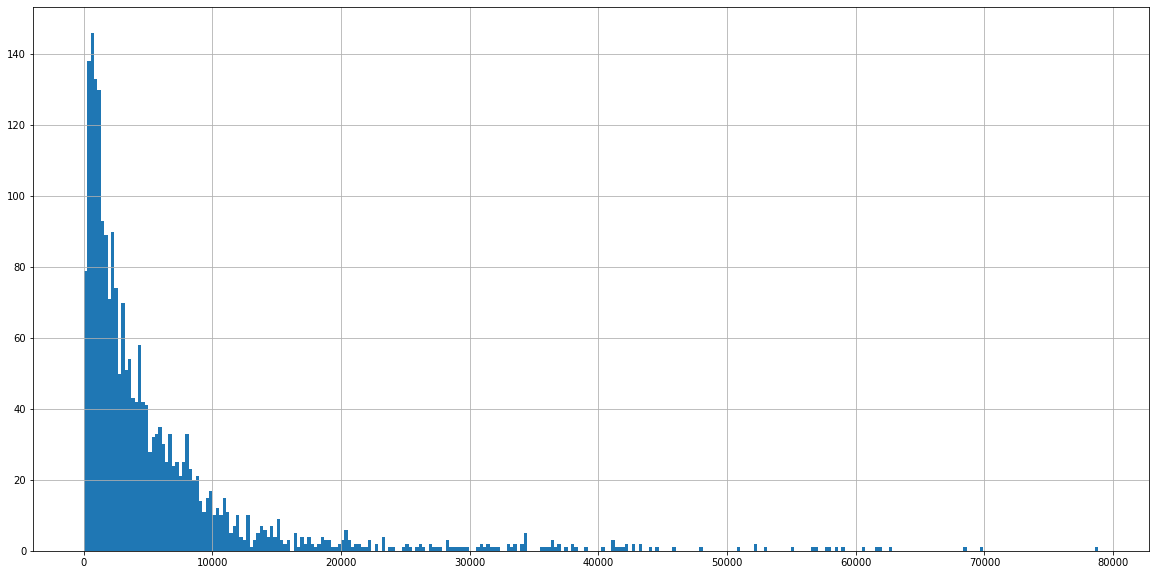

In [ ]:
news.text.str.split().apply(lambda x: len(x)).hist(bins=300)

####Text summarization

In [ ]:
pip install bert-extractive-summarizer

In [ ]:
from summarizer import Summarizer

model = Summarizer()

In [9]:
path_to_folder = 'drive/MyDrive/data/summarized_text/'

In [ ]:
for i in range(len(list_of_news)):
  list_of_news[i].text_summarized = list_of_news[i].text.apply(
      lambda x: model(x, num_sentences=10)
  )
  list_of_news[i].to_csv(
      path_to_folder + 
      f'{list_of_tickers[i]}_summarized_texts_one_day.csv'
  )

In [ ]:
news.to_csv('drive/MyDrive/data/AAPL_summarized_texts_one_day.csv')

In [11]:
summarized_texts = pd.read_csv(
    path_to_folder + 'MSFT_summarized_texts_one_day.csv',
    parse_dates=True,
    index_col=0
)

summarized_texts.head()

,text
datetime,
2008-10-15,U S stocks retreat after initial rescue pla...
2008-12-08,Corrects 3rd paragraph to show Black Friday i...
2008-12-24,TOKYO Dec 25 Reuters Game maker Nintendo ...
2009-01-15,Eric Auchard is a Reuters columnist The op...
2009-01-19,TOKYO Jan 20 Reuters Japanese game softwa...


In [ ]:
summarized_texts.text.str.split().apply(lambda x: len(x)).quantile(.75)

6777.0

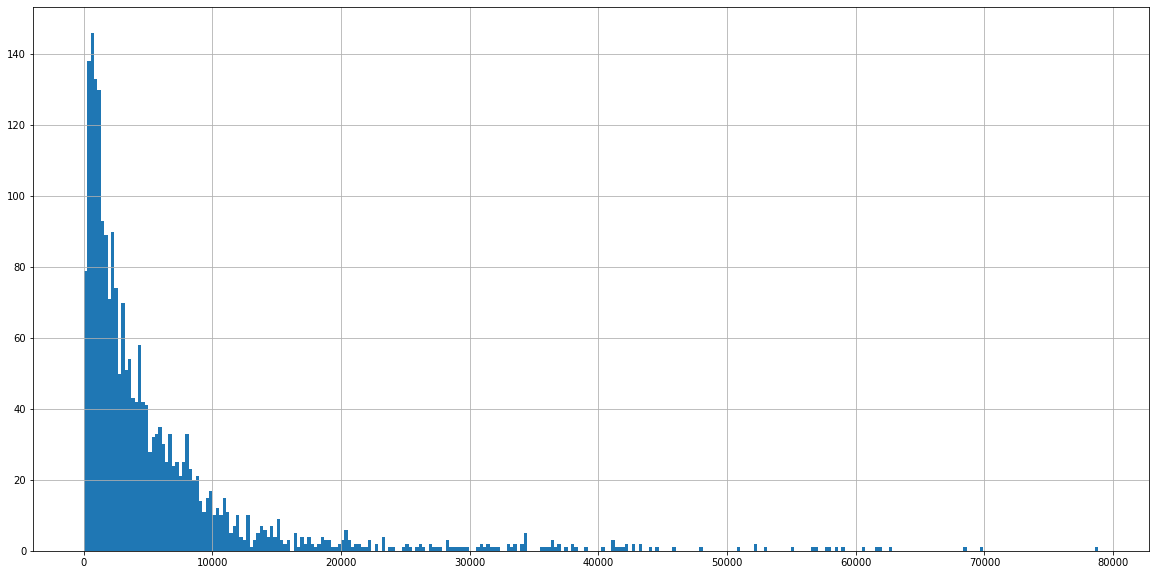

In [ ]:
summarized_texts.dropna().text.str.split().apply(lambda x: len(x)).hist(bins=300)

In [ ]:
summarized_texts.isna().sum()

text    0
dtype: int64

#Loading summarized texts

In [24]:
dict_of_summarized_texts = {}
path = 'drive/MyDrive/data/summarized_text/'
for file_name in listdir(path):
  ticker = file_name.split('_')[0]
  summarized_text = pd.read_csv(
      path + file_name, parse_dates=True, index_col=0
  )
  dict_of_summarized_texts[ticker] = summarized_text

# Merging prices and news

In [30]:
dict_of_merged = {}
for ticker in dict_of_returns.keys():
  dict_of_merged[ticker] = dict_of_returns[ticker][['target']].merge(
    dict_of_summarized_texts[ticker], left_index=True, right_index=True
)

In [47]:
merged = pd.concat(dict_of_merged).reset_index()[['target', 'text']]

In [46]:
merged.to_csv(
    'drive/MyDrive/data/merged.csv'
)

In [ ]:
news = pd.read_csv(
    'drive/MyDrive/data/news/sber_news_cleaned.csv',
    parse_dates=True,
    index_col=0
)

news.head()

,title,text
datetime,,
2020-08-12 16:44:00,"Греф не видит ""пузыря"" на российском фондовом ...","Греф не видит ""пузыря"" на российском фондовом ..."
2020-08-12 15:00:00,Рынок акций Московской биржи по состоянию на 1...,Рынок акций Московской биржи по состоянию на 1...
2020-08-12 15:22:00,Сбербанк признан достаточно устойчивой ко всем...,Сбербанк признан достаточно устойчивой ко всем...
2020-08-12 13:22:00,Рынок акций Московской биржи по состоянию на 1...,Рынок акций Московской биржи по состоянию на 1...
2020-08-12 16:22:00,Рынок акций Московской биржи по состоянию на 1...,Рынок акций Московской биржи по состоянию на 1...


In [ ]:
news = summarized_texts

In [ ]:
merged = returns[['target']].merge(
    news, left_index=True, right_index=True
)

merged.columns = ['target', 'text']

merged.head()

,target,text
datetime,,
2012-07-16,up,This stock market has been a difficult one for...
2012-07-19,down,From 2004 to 2010 the TSX 300 Index of leading...
2012-07-23,up,Europe flares as summer heat continues Summer...
2012-07-24,down,That is the sound we are going to hear soon fr...
2012-07-27,up,Apple s AAPL sales for the third quarter mis...


In [ ]:
merged.target.value_counts()

up      923
down    817
Name: target, dtype: int64

In [48]:
print('Merged data shape: ', merged.shape)
print('Num of "ups": ', len(merged[merged.target == 'up']))
print('Num of "downs": ', len(merged[merged.target == 'down']))
print('Num of "nothings": ', len(merged[merged.target == 'nothing']))

Merged data shape:  (65756, 2)
Num of "ups":  33936
Num of "downs":  31820
Num of "nothings":  0


In [49]:
merged['target'] = merged.target.replace(label_dict)
merged.head()

,target,text
0,0,This stock market has been a difficult one for...
1,1,From 2004 to 2010 the TSX 300 Index of leading...
2,0,Europe flares as summer heat continues Summer...
3,1,That is the sound we are going to hear soon fr...
4,0,Apple s AAPL sales for the third quarter mis...


In [ ]:
merged.to_csv(
    'drive/MyDrive/data/merged.csv'
)

# Splitting the merged data on train and test

In [50]:
# ПЕРЕГРУЗИ merged, ДОЛБОЁБ!

X_train, X_val, y_train, y_val = train_test_split(
    merged.index.values, 
    merged.target.values, 
    test_size=0.1, 
    stratify=merged.target.values,
    random_state=1
)

for key, value in label_dict.items():
  print(
      f"Ratio of '{key}s' in val and train",
      len(y_val[y_val == value]) / len(y_train[y_train == value])
  )

Ratio of 'ups' in val and train 0.11112566302141313
Ratio of 'downs' in val and train 0.1111111111111111


In [51]:
np.savetxt('drive/MyDrive/data/whole_text/X_train.txt', X_train)
np.savetxt('drive/MyDrive/data/whole_text/X_val.txt', X_val)
np.savetxt('drive/MyDrive/data/whole_text/y_train.txt', y_train)
np.savetxt('drive/MyDrive/data/whole_text/y_val.txt', y_val)

In [52]:
X_train1 = np.loadtxt('drive/MyDrive/data/whole_text/X_train.txt')
X_val1 = np.loadtxt('drive/MyDrive/data/whole_text/X_val.txt')
y_train1 = np.loadtxt('drive/MyDrive/data/whole_text/y_train.txt')
y_val1 = np.loadtxt('drive/MyDrive/data/whole_text/y_val.txt')

In [53]:
print(all(X_train == X_train1))
print(all(X_val == X_val1))
print(all(y_train == y_train1))
print(all(y_val == y_val1))

True
True
True
True


In [54]:
print(all(merged.loc[X_train1, 'target'].values == y_train1))
print(all(merged.loc[X_val1, 'target'].values == y_val1))

True
True


#Preparing the data for a model

In [55]:
merged.target.value_counts()

0    33936
1    31820
Name: target, dtype: int64

In [56]:
X_train = np.loadtxt('drive/MyDrive/data/whole_text/X_train.txt')
X_val = np.loadtxt('drive/MyDrive/data/whole_text/X_val.txt')
y_train = np.loadtxt('drive/MyDrive/data/whole_text/y_train.txt')
y_val = np.loadtxt('drive/MyDrive/data/whole_text/y_val.txt')

In [57]:
merged['data_type'] = ['not_set'] * merged.shape[0]

merged.loc[X_train, 'data_type'] = 'train'
merged.loc[X_val, 'data_type'] = 'val'

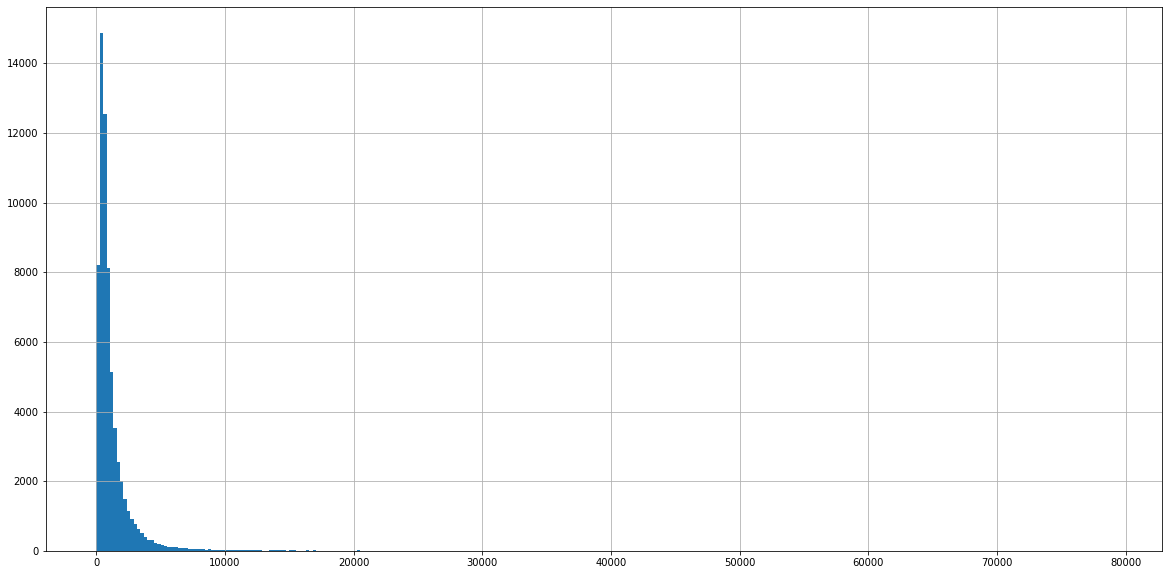

In [58]:
merged.text.str.split().apply(lambda x: len(x)).hist(bins=300)

In [59]:
tokenizer = AutoTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    list(merged.loc[X_train, 'text'].values), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=450, 
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    list(merged.loc[X_val, 'text'].values), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=450, 
    return_tensors='pt',
    truncation=True
)

In [60]:
with open(
    'drive/MyDrive/data/whole_text/encoded_data_train.pickle', 'wb'
) as f:
  pickle.dump(encoded_data_train, f)

with open(
    'drive/MyDrive/data/whole_text/encoded_data_val.pickle', 'wb'
) as f:
  pickle.dump(encoded_data_val, f)


# Building the model

In [1]:
import pickle

with open(
    'drive/MyDrive/data/whole_text/encoded_data_train.pickle', 'rb'
) as f:
  encoded_data_train = pickle.load(f)

with open(
    'drive/MyDrive/data/whole_text/encoded_data_val.pickle', 'rb'
) as f:
  encoded_data_val = pickle.load(f)

In [6]:
y_train = np.loadtxt('drive/MyDrive/data/whole_text/y_train.txt')
y_val = np.loadtxt('drive/MyDrive/data/whole_text/y_val.txt')

In [7]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train, dtype=torch.long)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val, dtype=torch.long)

In [8]:
dataset_train = TensorDataset(
    input_ids_train, attention_masks_train, labels_train
)
dataset_val = TensorDataset(
    input_ids_val, attention_masks_val, labels_val
)

In [9]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
device

device(type='cuda')

In [12]:
#3 КЛАССА !

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_dict),
    output_attentions=False,
    output_hidden_states=False
)

model.to(device)

'''model.load_state_dict(
    torch.load('drive/MyDrive/models/finetuned_BERT_epoch_13.model', 
    map_location=torch.device('cpu'))
)'''

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

"model.load_state_dict(\n    torch.load('drive/MyDrive/models/finetuned_BERT_epoch_13.model', \n    map_location=torch.device('cpu'))\n)"

In [13]:
batch_size = 16

dataloader_train = DataLoader(
    dataset_train, 
    sampler=RandomSampler(dataset_train), 
    batch_size=batch_size
)

dataloader_validation = DataLoader(
    dataset_val, 
    sampler=SequentialSampler(dataset_val), 
    batch_size=batch_size
)

In [14]:
optimizer = AdamW(
    model.parameters(),
    lr=1e-5, 
    eps=1e-8
)
                  
epochs = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

#Training loop


In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(
        dataloader_train, 
        desc='Epoch {:1d}'.format(epoch), 
        leave=False, 
        disable=False
    )
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix(
            {'training_loss': '{:.3f}'.format(loss.item()/len(batch))}
        )
         
        
    torch.save(
        model.state_dict(), 
        f'drive/MyDrive/models/finetuned_BERT_epoch_{epoch}.model'
    )
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_acc = accuracy_per_class(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    val_acc


Epoch 1
Training loss: 0.6944978389104465
Class: up
Accuracy: 3364/3394

Class: down
Accuracy: 34/3182

Validation loss: 0.6929297312332766
F1 Score (Weighted): 0.36067683975500825



Epoch 2
Training loss: 0.6936238066155578
Class: up
Accuracy: 3394/3394

Class: down
Accuracy: 0/3182

Validation loss: 0.6929817185204684
F1 Score (Weighted): 0.3513959152396362



Epoch 3
Training loss: 0.6932383222365965
Class: up
Accuracy: 3394/3394

Class: down
Accuracy: 0/3182

Validation loss: 0.6951788334660867
F1 Score (Weighted): 0.3513959152396362



Epoch 4
Training loss: 0.6927152877080824
Class: up
Accuracy: 3252/3394

Class: down
Accuracy: 121/3182

Validation loss: 0.7022738131873509
F1 Score (Weighted): 0.3798074055163



Epoch 5
Training loss: 0.681845322561509
Class: up
Accuracy: 2990/3394

Class: down
Accuracy: 359/3182

Validation loss: 0.7160043482942883
F1 Score (Weighted): 0.42328996164055455



Epoch 6
Training loss: 0.6303217653633292
Class: up
Accuracy: 2242/3394

Class: down
Accuracy: 1049/3182

Validation loss: 0.8013102111300122
F1 Score (Weighted): 0.4864766438407899



Epoch 7
Training loss: 0.5369771473566949
Class: up
Accuracy: 1986/3394

Class: down
Accuracy: 1284/3182

Validation loss: 0.9219695253528818
F1 Score (Weighted): 0.4932176832134601



Epoch 8
Training loss: 0.4342191607408602
Class: up
Accuracy: 2243/3394

Class: down
Accuracy: 1034/3182

Validation loss: 1.207306047135606
F1 Score (Weighted): 0.48385447735569725



Epoch 9
Training loss: 0.33934952005659386
Class: up
Accuracy: 2341/3394

Class: down
Accuracy: 984/3182

Validation loss: 1.4212527403431217
F1 Score (Weighted): 0.48707345217635545



Epoch 10
Training loss: 0.2732729091990445
Class: up
Accuracy: 2148/3394

Class: down
Accuracy: 1174/3182

Validation loss: 1.4871275673672522
F1 Score (Weighted): 0.4964871200618391



Epoch 11
Training loss: 0.22467435790883253
Class: up
Accuracy: 1937/3394

Class: down
Accuracy: 1355/3182

Validation loss: 1.9875416569321116
F1 Score (Weighted): 0.4981018307332459



Epoch 12
Training loss: 0.19739557512929207
Class: up
Accuracy: 1876/3394

Class: down
Accuracy: 1405/3182

Validation loss: 2.348987227228726
F1 Score (Weighted): 0.49751475125760813



Epoch 13
Training loss: 0.177582256928757
Class: up
Accuracy: 2150/3394

Class: down
Accuracy: 1149/3182

Validation loss: 2.4309420376798534
F1 Score (Weighted): 0.4923555892835015



Epoch 14
Training loss: 0.16634286180935526
Class: up
Accuracy: 2236/3394

Class: down
Accuracy: 1070/3182

Validation loss: 2.5719110149246642
F1 Score (Weighted): 0.48953088727836025



Epoch 15
Training loss: 0.15921912576841663
Class: up
Accuracy: 2193/3394

Class: down
Accuracy: 1136/3182

Validation loss: 2.678857641208491
F1 Score (Weighted): 0.4957660023244595



Epoch 16
Training loss: 0.14541350964518607
Class: up
Accuracy: 2053/3394

Class: down
Accuracy: 1239/3182

Validation loss: 2.9211195209890675
F1 Score (Weighted): 0.4948612281677063



Epoch 17
Training loss: 0.13632416239256512
Class: up
Accuracy: 2080/3394

Class: down
Accuracy: 1253/3182

Validation loss: 2.9397657419353216
F1 Score (Weighted): 0.5009496685068057



Epoch 18
Training loss: 0.12612692942727236
Class: up
Accuracy: 2274/3394

Class: down
Accuracy: 1065/3182

Validation loss: 3.158843621140269
F1 Score (Weighted): 0.4935546963323407



Epoch 19
Training loss: 0.11767938426794976
Class: up
Accuracy: 2055/3394

Class: down
Accuracy: 1276/3182

Validation loss: 3.3340104007662936
F1 Score (Weighted): 0.5014269695718226



Epoch 20
Training loss: 0.10901919577176794
Class: up
Accuracy: 2099/3394

Class: down
Accuracy: 1247/3182

Validation loss: 3.7773908388295605
F1 Score (Weighted): 0.5025207024732914


# Additional test

In [ ]:
device = 'cpu'
device

'cpu'

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

#model.to(device)

path_to_model = 'drive/MyDrive/data/whole_text/saved_models/'
model_name = 'five_min_next_candle_titles_mean_std.model'
model.load_state_dict(
    torch.load(path_to_model + model_name, 
    map_location=torch.device('cpu'))
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

<All keys matched successfully>

In [ ]:
with open(
    'drive/MyDrive/data/whole_text/saved_models/for_deploy.pickle', 'wb'
) as f:
  pickle.dump(model, f)

In [ ]:
val_loss, predictions, true_vals = evaluate(dataloader_train)
val_f1 = f1_score_func(predictions, true_vals)
val_acc = accuracy_per_class(predictions, true_vals)

Class: up
Accuracy: 2/2042

Class: down
Accuracy: 1992/1992



In [ ]:
merged.loc[X_train, :].query("target == 1").sort_index()

,target,text
3.0,1,Рынки Азии закрылись выше в понедельник; Nikke...
4.0,1,Рынки Азии поднялись на фоне оптимизма по пово...
5.0,1,Азиатские акции выросли; ВВП Японии подняло ин...
6.0,1,Азиатские фондовые рынки значительно выросли; ...
7.0,1,Азиатские фондовые рынки упали из-за продолжа...
...,...,...
4469.0,1,Квартальная прибыль Puma выросла на 13%
4477.0,1,Volkswagen вернулся к прибыли в 3 кв благодаря...
4479.0,1,Рынок Азии упал из-за приближения выборов в США
4481.0,1,Акции - самый перспективный актив для инвестиц...


In [ ]:
merged.tail(20)

,target,text
4463,1,Азиатские индексы в основном выросли вслед за ...
4464,0,Японские акции закрылись ростом на фоне надежд...
4465,0,Белнефтехим сообщил о временной приостановке т...
4466,0,Фондовая Америка торгуется разнонаправленно
4467,1,"""Детский мир"" на 0,4% увеличил чистую прибыль ..."
4468,1,"Novartis увеличила прибыль в 3 кв, повысила пр..."
4469,1,Квартальная прибыль Puma выросла на 13%
4470,0,Индекс МосБиржи упал ниже 2700 пунктов
4471,0,Акции Mastercard падают из-за снижения квартал...
4472,0,"Ччистая прибыль ""НОВАТЭКа"" за 3-й квартал по М..."


In [ ]:
returns.tail(20)

,returns_to_high,returns_to_low,target,max_abs_return
datetime,,,,
2020-10-29 10:55:00,0.003826,-0.001369,up,0.003826
2020-10-29 11:05:00,0.000243,-0.004129,down,-0.004129
2020-10-29 11:15:00,-0.000837,-0.006483,down,-0.006483
2020-10-29 11:20:00,0.004347,0.000586,up,0.004347
2020-10-29 11:35:00,-0.000750,-0.003573,down,-0.003573
2020-10-29 11:40:00,-0.001132,-0.006692,down,-0.006692
2020-10-29 11:55:00,0.004522,-0.000039,up,0.004522
2020-10-29 12:20:00,0.003879,0.000614,up,0.003879
2020-10-29 12:30:00,-0.000720,-0.003347,down,-0.003347


In [ ]:
encoded_data_train['input_ids'].shape

torch.Size([32791, 70])

In [ ]:
input_id = torch.reshape(encoded_data_train['input_ids'][0], (1, 70))
attention_mask = torch.reshape(encoded_data_train['attention_mask'][0], (1, 70))

attention_mask.shape

torch.Size([1, 70])

In [ ]:
predictions = []
with torch.no_grad():
  for i in range(32791):
    input_id = torch.reshape(encoded_data_train['input_ids'][i], (1, 70))
    attention_mask = torch.reshape(
        encoded_data_train['attention_mask'][i], (1, 70)
    )
    pred = model(input_id, attention_mask)
    pred = np.argmax(pred).flatten()
    predictions.append(pred)

In [ ]:
len(predictions)

32791

In [ ]:
X_train[np.array(predictions).reshape((32791)) == y_train]

ValueError: ignored

In [ ]:
predictions_val = []
with torch.no_grad():
  for i in range(3644):
    input_id = torch.reshape(encoded_data_val['input_ids'][i], (1, 70))
    attention_mask = torch.reshape(
        encoded_data_val['attention_mask'][i], (1, 70)
    )
    pred = model(input_id, attention_mask)
    pred = np.argmax(pred).flatten()
    predictions_val.append(pred)

In [ ]:
encoded_data_val['attention_mask'].shape

torch.Size([3644, 70])

In [ ]:
(np.array(predictions_val).reshape((3644)) == y_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


array([], shape=(0, 4034), dtype=float64)

In [ ]:
merged.head(10)

,target,text
0,0,Азиатские акции показали разнонаправленную дин...
1,0,Азиатские биржи показали разнонаправленную дин...
2,0,Азиатские биржи разделились по динамике из-за ...
3,1,Рынки Азии закрылись выше в понедельник; Nikke...
4,1,Рынки Азии поднялись на фоне оптимизма по пово...
5,1,Азиатские акции выросли; ВВП Японии подняло ин...
6,1,Азиатские фондовые рынки значительно выросли; ...
7,1,Азиатские фондовые рынки упали из-за продолжа...
8,0,Азиатские акции смешались на фоне ситуации в Е...
9,0,Азиатские фондовые рынки поднялись на фоне спа...


# Deploying the model

In [ ]:
pip install --upgrade azureml-sdk

In [ ]:
PATH_TO_MODEL = 'drive/MyDrive/data/whole_text/saved_models/'
MODEL_FILE = 'short_predictor.joblib'

In [ ]:
import joblib

joblib.dump(model, PATH_TO_MODEL + MODEL_FILE)

['drive/MyDrive/data/whole_text/saved_models/short_predictor.joblib']

In [ ]:
import joblib

model = joblib.load(PATH_TO_MODEL + MODEL_FILE)

In [ ]:
from azureml.core import Workspace
from azureml.core import Model

ws = Workspace.from_config(
    path=PATH_TO_MODEL + 'config.json'
)

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code SDAEZPE66 to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.


In [ ]:
model = Model.register(
    workspace = ws,
    model_path =PATH_TO_MODEL + MODEL_FILE,
    model_name = "sber_short_predictor",
    model_framework=Model.Framework.PYTORCH,
)

In [ ]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

environment = Environment("my-custom-environment")

environment.python.conda_dependencies = CondaDependencies.create(pip_packages=[
    'azureml-defaults>= 1.0.45', # mandatory dependency, contains the functionality needed to host the model as a web service
    'inference-schema[numpy-support]', # dependency for automatic schema generation (for parsing and validating input data)
    'joblib',
    'numpy',
    'torch',
    'transformers'
])

from azureml.core.model import InferenceConfig

entry_script = PATH_TO_MODEL + 'score.py'
inference_config = InferenceConfig(
  entry_script=entry_script, 
  environment=environment
)

In [ ]:
from azureml.core.webservice import AciWebservice

aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=2)

In [ ]:
MODEL_NAME = 'short_predictor'
ENDPOINT_NAME = 'short-predictor-ep'

# Locate the model in the workspace
model = Model(ws, name=MODEL_NAME)

# Deploy the model as a real-time endpoint
service = Model.deploy(
    ws, ENDPOINT_NAME, [model],
    inference_config=inference_config,
    deployment_config=aci_config
)

In [ ]:
import torch

num = 13

input_id = torch.reshape(encoded_data_train['input_ids'][num], (1, 70)).tolist()
attention_mask = torch.reshape(
    encoded_data_train['attention_mask'][num], (1, 70)
).tolist()

import numpy as np


with torch.no_grad():
  print(np.argmax(model(torch.tensor(input_id), torch.tensor(attention_mask))[0]))

tensor(1)


In [ ]:
import numpy as np


with torch.no_grad():
  print(np.argmax(model(torch.tensor(input_id), torch.tensor(attention_mask))[0]))

tensor(1)


In [ ]:
import json
import requests

scoring_uri = 'http://b8c4ea9c-1f2e-4c40-9443-0892038e0bbe.eastus2.azurecontainer.io/score'

data = {
  'ids': input_id,
  'mask': attention_mask
}

input_data = json.dumps(data)

headers = {"Content-Type": "application/json"}

resp = requests.post(scoring_uri, input_data, headers=headers)

result = json.loads(resp.text)

In [ ]:
resp.text

'{"result": 1}'